# LBM Demo Extraction 

In [1]:
## Imports
%load_ext autoreload
%autoreload 2

import time
import sys
from pathlib import Path
import numpy as np
import pandas as pd

sys.path.append('../../util/')  # TODO: Take this out when we upload to pypi
sys.path.append('../..')  # TODO: Take this out when we upload to pypi
import matplotlib.pyplot as plt
import dask
import zarr
import scanreader as sr

%matplotlib inline

In [12]:
## System and User Information
get_sys_info=True

if get_sys_info:
    !pip install cloudmesh-cmd5
    !cms help # sets some defaults
    !cms sysinfo

Sourcing .zshenv...
Sourcing .zshenv...

Documented commands (type help <topic>):
EOF     commands  dryrun  info   py    set    stopwatch  var    
banner  debug     echo    man    q     shell  sysinfo    version
clear   default   help    pause  quit  sleep  term     

Sourcing .zshenv...
+---------------------+-------------------------------------------------------------------------------+
| Attribute           | Value                                                                         |
+---------------------+-------------------------------------------------------------------------------+
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                                          |
| DISTRIB_CODENAME    | jammy                                                                         |
| DISTRIB_DESCRIPTION | "Ubuntu 22.04.4 LTS"                                                          |
| DISTRIB_ID          | Ubuntu                                                         

## Set up filepaths

In [2]:
# ScanReader object holds our image data with tifffile
parent_dir = Path().home() / 'caiman_data'
raw_dir = parent_dir / 'high_res'
raw_files = [str(x) for x in raw_dir.glob("*.tif*")]
raw_files

['/home/mbo/caiman_data/high_res/MH70_0p6mm_FOV_50_550um_depth_som_stim_199mW_3min_M1_00001_00001.tif',
 '/home/mbo/caiman_data/high_res/raw_p1.tif']

## scanreader 

### Extract data using [scanreader (docs)](https://millerbrainobservatory.github.io/scanreader/index.html), joining contiguous ROI's, and plot our mean image

Our ScanReader object contains all of the properties needed to keep track of our raw data. 
- ScanImage metadata is stored alongside header metadata, this ScanImage specific data is what's needed to assemble frames from constituent ROIs.
- We calculate the frame rate and time/pixels between scans and ROI's using the following metadata:

### Joining Contiguious ROI's

```python
import scanreader as sr

path = Path().home() / 'caiman_data' # or: path = Path('C:/Users/MBO/caiman_data')
scan = sr.read_scan(path, join_contiguous=True, debug=True)

# loop through z-planes and display a single frame
for i in range(0, _scan.shape[1]-1):
    new_arr = _scan[0,i,:,:]
    plt.imshow(new_arr)

data = sr.read_scan(raw_files)
data.shape()
```

Setting `join_contiguous=True` will combine ROI's with the following constraints:

1) Must be the same size/shape
2) Must be located in the same scanning depth
3) Must be located in the same slice

In [3]:
reader = sr.read_scan(raw_files[0])
reader.shape

(1730, 30, 2478, 145)

In [7]:
np.mean(reader[1:3,2,:,:], axis=-1).shape

(600, 576)

(-0.5, 575.5, 599.5, -0.5)

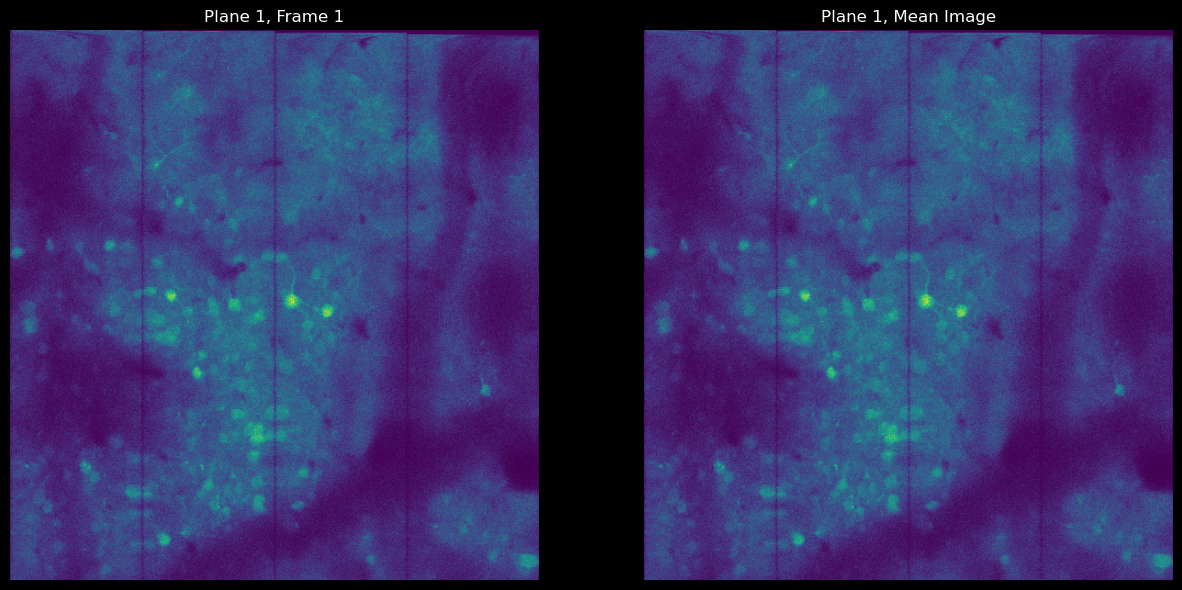

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(reader[1,1,:,:])
ax[0].axis('off')
ax[0].set_title('Plane 1, Frame 1')
ax[1].imshow(np.mean(reader[1:,1,:,:], axis=-1))
ax[1].set_title('Plane 1, Mean Image')
ax[1].axis('off')

In [37]:
test = reader[:200,2,:,:]
test.shape
#np.mean(reader[:200,2,:,:], axis=0)

(600, 576, 200)

In [49]:
df = pd.DataFrame(index=range(0, reader.num_channels), columns=['Channel', 'Mean Time'])

def plot_mean_images(_reader):
    fig, ax = plt.subplots(5, 5, figsize=(15, 15))
    ax = ax.flatten()

    for idx in range(min(25, _reader.num_channels)):
        # extract and plot mean image for each z-plane
        plane = _reader[2:200, idx, :, :]
        mean_image = np.mean(plane, axis=-1)
        ax[idx].imshow(mean_image, cmap='gray')
        ax[idx].axis('off')

    plt.tight_layout()
    plt.show()

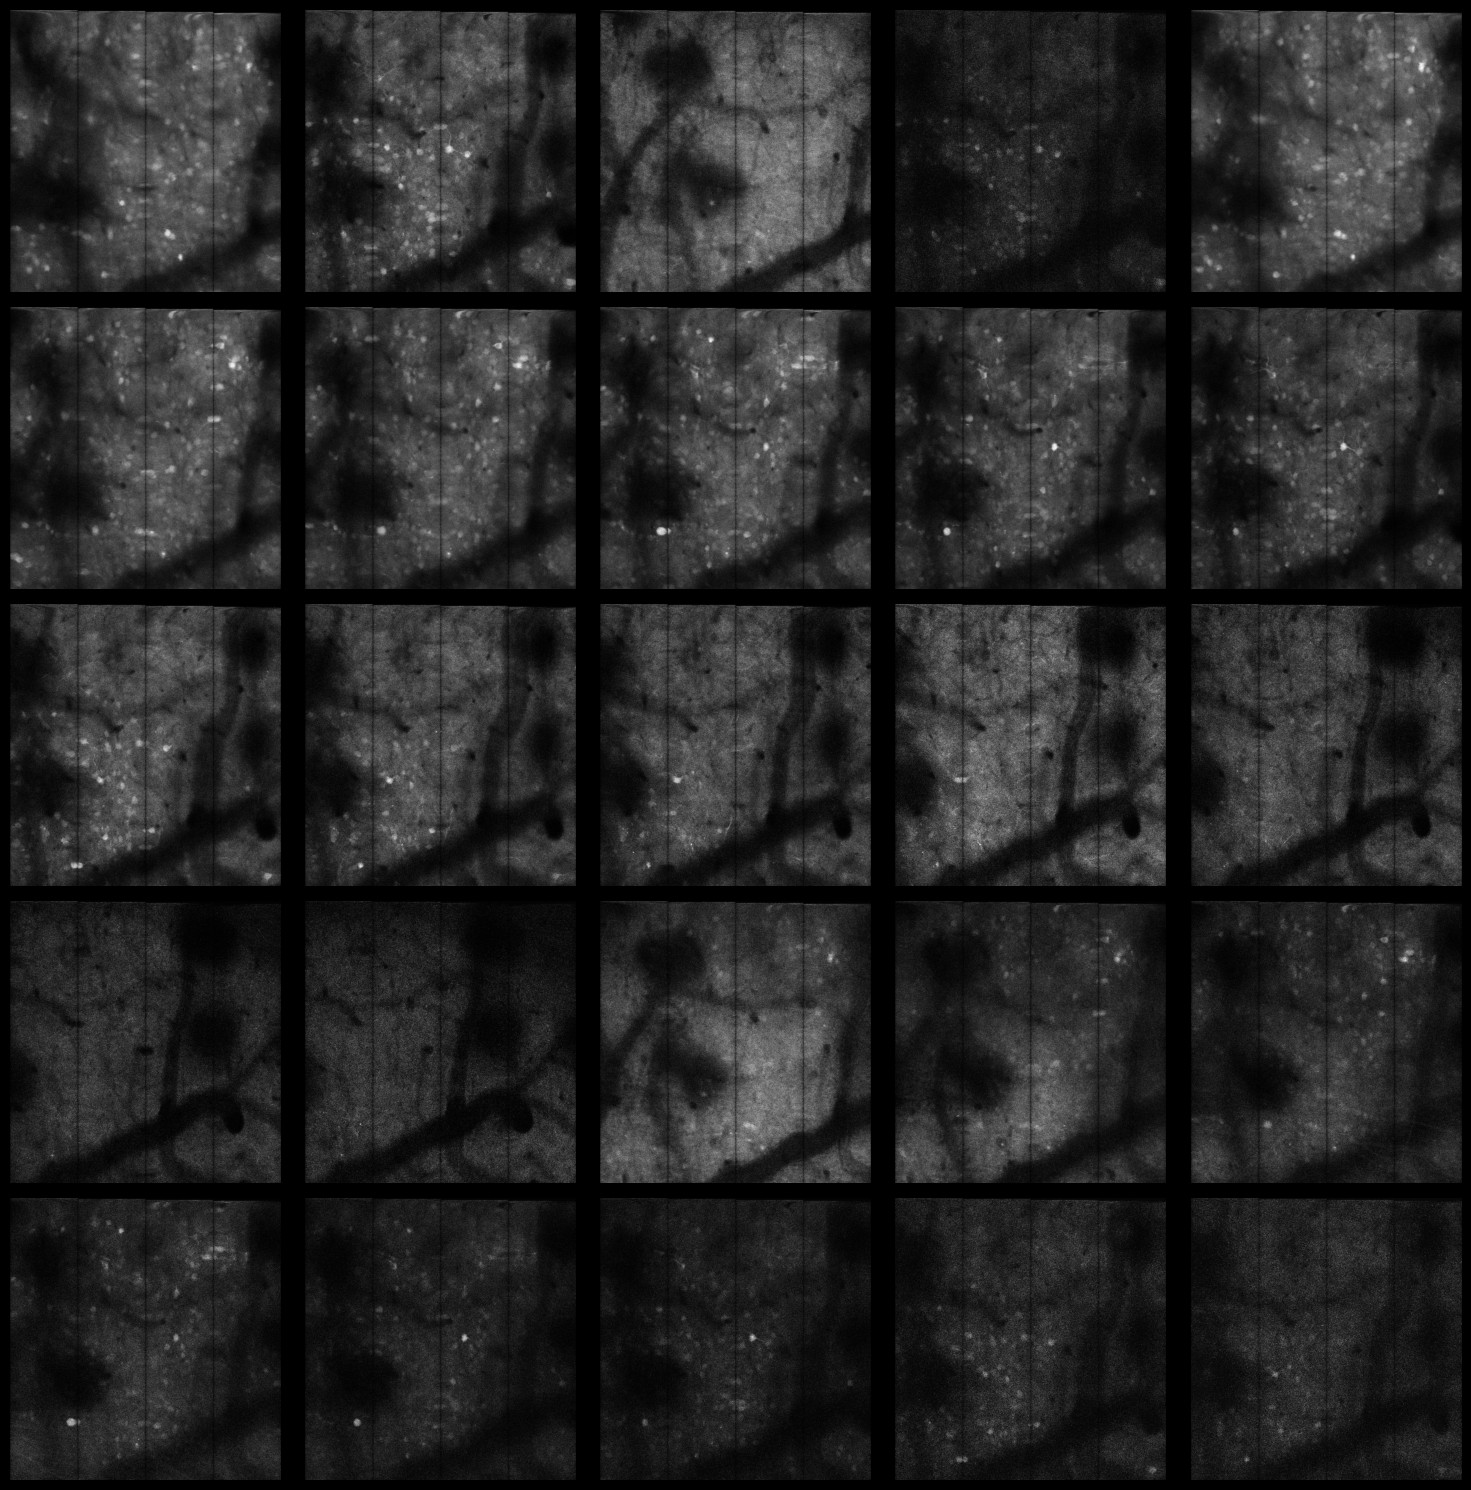

In [50]:
plot_mean_images(reader)

## Save as `.tiff`

In [52]:
import tifffile
import time

for idx, num in enumerate(range(1, reader.num_channels + 1)):
    if idx == 0:
        # field, X, Y, Z, T
        plane = reader[:, idx, :].squeeze()
        print(plane.shape)
        start = time.time()
        with tifffile.TiffWriter(raw_dir / f'raw_p{num}.tif', bigtiff=True) as tif:
            for frame in range(reader.num_frames):
                tif.write(plane[:, :, frame], metadata={'fps': reader.fps})
        e1 = time.time()
        plane = np.transpose(plane,(2,0,1))
        with tifffile.TiffWriter(raw_dir / f'raw_p{num}_tp.tif', bigtiff=True) as tif:
            for frame in range(reader.num_frames):
                tif.write(plane[frame, :, :], metadata={'fps': reader.fps})
        e2 = time.time()
        print((e1,e2))
test = tifffile.imread(extracted_path / "plane_1.tif")

(600, 576, 1730)


KeyError: 'si'